Titanic Survival Rate

we will analyze survived rate in titanic with decission tree classifier

First, We import all module that we need

In [14]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

Import dataset source that we use, i get this dataset from kaggle but i also put on this repository

In [15]:
df = pd.read_csv("../CSV file/titanic.csv")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,deck
0,0,3,male,22.0,1,0,7.2500,S,NaN
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,S,NaN
3,1,1,female,35.0,1,0,53.1000,S,C
4,0,3,male,35.0,0,0,8.0500,S,NaN


do null value detection

In [16]:
df.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
deck        688
dtype: int64

Cause the percentage of age and deck columns' null values are too big, I will convert null become average age (for age columns) and for deck columns, i will convert it into unknown

In [17]:
#remove Null - Age
df["age"] =  df["age"].fillna(np.mean(df.age))

#remove Null - Deck
df.deck = df["deck"].fillna("unknown")

and because there is only 2 null's in embarked columns, i will remove it 

In [18]:
#remove Null - Embarked
df.dropna(inplace=True)

In [19]:
df.isna().sum()

survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
deck        0
dtype: int64

Survived distribution based on each column

<AxesSubplot:xlabel='parch'>

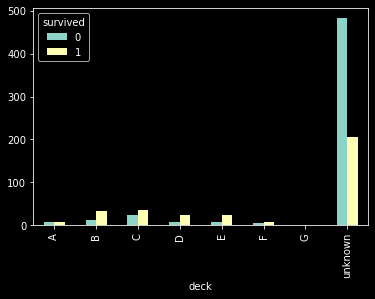

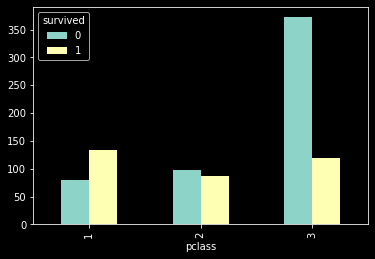

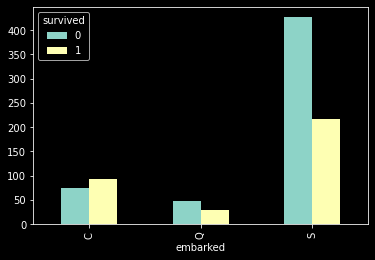

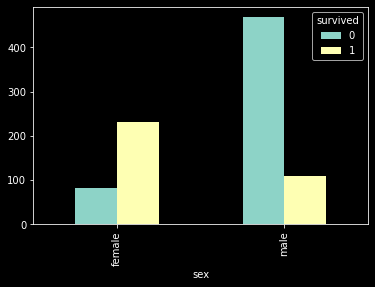

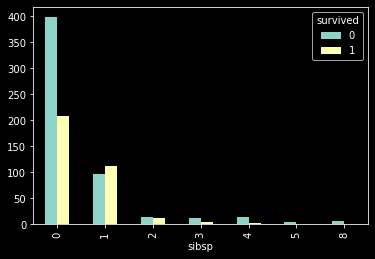

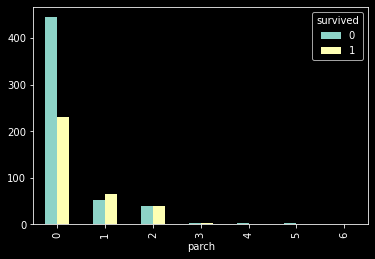

In [20]:
#visualization columns distributions
pd.crosstab(df.deck, df.survived).plot(kind="bar")
pd.crosstab(df.pclass, df.survived).plot(kind="bar")
pd.crosstab(df.embarked, df.survived).plot(kind="bar")
pd.crosstab(df.sex, df.survived).plot(kind="bar")
pd.crosstab(df.sibsp, df.survived).plot(kind="bar")
pd.crosstab(df.parch, df.survived).plot(kind="bar")

From the visualization above, there are columns which doesn't have an impact on survival rate there is :
- Age
- fare
- embarked
- parch & sibsp

so I will drop those columns

In [21]:
#remove columns
df = df.drop(["age", "fare", "embarked", "parch", "sibsp"], axis="columns")
df.head()

,survived,pclass,sex,deck
0,0,3,male,unknown
1,1,1,female,C
2,1,3,female,unknown
3,1,1,female,C
4,0,3,male,unknown


Convert text columns to numeric

In [22]:
#deck OHE
df_dums = pd.get_dummies(df[["deck"]])
df_dums.head()
df = pd.concat([df_dums, df], axis="columns")

df.drop(["deck"], axis="columns", inplace=True)

#sex OHE
le = LabelEncoder()
df["sex"] = le.fit_transform(df.sex)

df.head()

,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_unknown,survived,pclass,sex
0,0,0,0,0,0,0,0,1,0,3,1
1,0,0,1,0,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,1,1,3,0
3,0,0,1,0,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,1,0,3,1


cause total survived and not survived data gaps are pretty big (549/340), I do oversample to minority data (survived columns) to tackle imbalance while training model

In [23]:
#oversampling
countcls =  df.survived.value_counts()
df0 = df[df["survived"] == 0]
df1 = df[df["survived"]== 1]

df0.shape
df1.shape

df1over = df1.sample(countcls[0], replace=True)
oversml = pd.concat([df0, df1over], axis=0)
oversml.shape

oversml = oversml.dropna()
oversml

,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_unknown,survived,pclass,sex
0,0,0,0,0,0,0,0,1,0,3,1
4,0,0,0,0,0,0,0,1,0,3,1
5,0,0,0,0,0,0,0,1,0,3,1
6,0,0,0,0,1,0,0,0,0,1,1
7,0,0,0,0,0,0,0,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...
577,0,0,0,0,1,0,0,0,1,1,0
2,0,0,0,0,0,0,0,1,1,3,0
751,0,0,0,0,1,0,0,0,1,3,1
701,0,0,0,0,1,0,0,0,1,1,1


features and target split then split it into training and testing dataset

In [24]:
X = oversml.drop(["survived"], axis="columns")
y = oversml["survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=10)

now i will build the Decission Tree classifier and give it parameter tuning, for searching best parameters i use GridseacrhCV with costumized min_sample_leaf and max_depth parameter

In [25]:
clf = DecisionTreeClassifier(random_state=5)

params =  {
    'min_samples_leaf': [1, 2, 3, 10, 20, 50, 100],
    'max_depth': [.1, 1, 2, 3, 5, 10, 20]
}

grid = GridSearchCV(estimator=clf,
                    param_grid=params,
                    cv=5,
                    n_jobs=5,
                    verbose=2)

grid.fit(X, y)
grid.best_score_, grid.best_params_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


(0.7795724366957244, {'max_depth': 5, 'min_samples_leaf': 1})

then i will build decission tree classifier algorithm and that model report

              precision    recall  f1-score   support

           0       0.66      0.83      0.74       117
           1       0.81      0.64      0.72       136

    accuracy                           0.73       253
   macro avg       0.74      0.73      0.73       253
weighted avg       0.74      0.73      0.73       253



Text(69.0, 0.5, 'truth value')

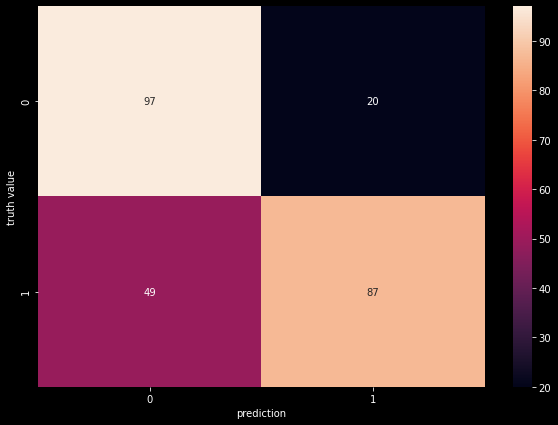

In [26]:
clf = DecisionTreeClassifier(random_state=5, max_depth=2, min_samples_leaf=1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

#model Report
print(classification_report(y_test, clf.predict(X_test)))

#confussion 
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), annot=True)
plt.xlabel("prediction")
plt.ylabel("truth value")